<a href="https://colab.research.google.com/github/umbertoselva/NER-based-Sentiment-Analysis/blob/main/03_Kaggle_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 KAGGLE DATASET

This is part 03 of my NER-based Sentiment Analysis Project: 
https://github.com/umbertoselva/NER-based-Sentiment-Analysis

Our goal here is to get a movie review dataset on which to later fine-tune a BERT model for Sentiment Analysis (see Part 04)

## GETTING THE DATASET

We shall use a dataset from Kaggle via the Kaggle API.

For this purpose we need to install `kaggle`, register an account on the Kaggle website and authenticate ourselves.

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we need to go to our Kaggle profile > Account > to the API section > Create New API token, save the newly created kaggle.jason file, and upload it here via the cell here below

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
# initialize api instance
api = KaggleApi()

In [ ]:
# authenticate api by automatically reading the uploaded kaggle.json file
api.authenticate()

We will be using the following dataset:
https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data

From the description (see the "Data Explorer" section at the above link) we can see that it contains two files:
- `test.tsv.zip`
- `train.tsv.zip`

So Kaggle has it listed among the competition datasets. Therefore, in order to download it, we need to use the `.competition_download_file()` method and feed the dataset name as first argument, the files that we want to download as second argument, and the download path as third. We need to do the same for each file.

N.B. Make sure that you agree to the competition rules on the Kaggle website with your account or you won't be able to download the files.

In [ ]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip', 
                              path='./')

100%|██████████| 494k/494k [00:00<00:00, 28.2MB/s]

In [ ]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', 
                              path='./')

100%|██████████| 1.28M/1.28M [00:00<00:00, 117MB/s]

In [ ]:
!pwd

/content


In [ ]:
!ls

sample_data  test.tsv.zip  train.tsv.zip


Let's unzip them

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipf:
  zipf.extractall('./') # target path

In [ ]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipf:
  zipf.extractall('./') # target path

In [ ]:
!ls

sample_data  test.tsv  test.tsv.zip  train.tsv	train.tsv.zip


## ADAPTING THE DATASET

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('train.tsv', sep='\t')

In [ ]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [ ]:
df.head(25)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


Our dataset contains movie reviews, then each review is split into sentences and smaller bits.

It is possible to remove all these duplicates, but keeping them helps with training.

In [ ]:
# code to remove duplicates and keep only the first item with the same ID
# df.drop_duplicates(subset=['SentenceId'], keep='first')

However, let's plot the values by sentiment label and have a look at the labels

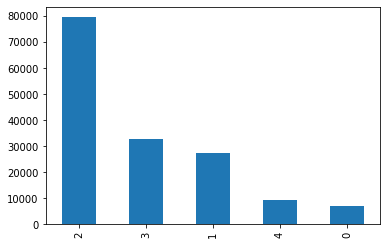

In [ ]:
df['Sentiment'].value_counts().plot(kind='bar')

The sentiment labels are:

- 0 = negative
- 1 = somewhat negative
- 2 = neutral
- 3 = somewhat positive
- 4 = positive

Ideally, we would like to only have two classes (positive vs negative).

We can adapt our dataset in various ways.

We can merge 1 with 0, and 3 with 4.

We can either merge 2 with 4 as well, or alternatively we can drop all the 2-labelled rows.

Let's drop all the neutral-labelled rows. Actually these won't be just neutral reviews, but also segments of reviews that might have different labels.

In [ ]:
# with this line we keep only the rows whose sentiment col value is not 2
df = df[df.Sentiment != 2]

In [ ]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
21,22,1,good for the goose,3
22,23,1,good,3
33,34,1,"the gander , some of which occasionally amuses...",1
46,47,1,amuses,3
...,...,...,...,...
156047,156048,8544,quietly suggesting the sadness and obsession b...,1
156051,156052,8544,sadness and obsession,1
156052,156053,8544,sadness and,1
156056,156057,8544,forced avuncular chortles,1


Our dataset dropped from 156,060 to 76,478 rows, but we'll make do.

Now let's merge the "somewhat negative" label (1) with the "negative" label (0).

In [ ]:
df['Sentiment'] = df["Sentiment"].replace(1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
21,22,1,good for the goose,3
22,23,1,good,3
33,34,1,"the gander , some of which occasionally amuses...",0
46,47,1,amuses,3
...,...,...,...,...
156047,156048,8544,quietly suggesting the sadness and obsession b...,0
156051,156052,8544,sadness and obsession,0
156052,156053,8544,sadness and,0
156056,156057,8544,forced avuncular chortles,0


And the "somewhat positive" label (3) with the "positive" label (4)

In [ ]:
df['Sentiment'] = df["Sentiment"].replace(3, 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
21,22,1,good for the goose,4
22,23,1,good,4
33,34,1,"the gander , some of which occasionally amuses...",0
46,47,1,amuses,4
...,...,...,...,...
156047,156048,8544,quietly suggesting the sadness and obsession b...,0
156051,156052,8544,sadness and obsession,0
156052,156053,8544,sadness and,0
156056,156057,8544,forced avuncular chortles,0


Now let's turn the 4 into a 1, so we'll have
- 0 = negative
- 1 = positive

In [ ]:
df['Sentiment'] = df["Sentiment"].replace(4, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
21,22,1,good for the goose,1
22,23,1,good,1
33,34,1,"the gander , some of which occasionally amuses...",0
46,47,1,amuses,1
...,...,...,...,...
156047,156048,8544,quietly suggesting the sadness and obsession b...,0
156051,156052,8544,sadness and obsession,0
156052,156053,8544,sadness and,0
156056,156057,8544,forced avuncular chortles,0


Let's plot our dataset again

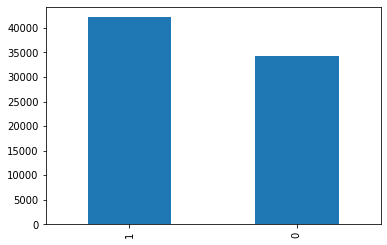

In [ ]:
df['Sentiment'].value_counts().plot(kind='bar')

That's a fairly balanced-looking dataset.

Let's save it to a CSV file for later use.

In [ ]:
df = df.replace({'|': ''}, regex=True)
df.to_csv('kaggle_movie_df.csv', sep='|', encoding='utf-8', index=False)

In [ ]:
!ls

kaggle_movie_df.csv  test.tsv	   train.tsv
sample_data	     test.tsv.zip  train.tsv.zip
